In [1]:
import numpy as np
import pandas as pd
import lasagne
import theano
import theano.tensor as T
import random
import time
import connect_four as cccc
#import seaborn
import matplotlib.pyplot as plt
%matplotlib inline


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
C:\Users\todds\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
#initialization

net = []
activation = lasagne.nonlinearities.tanh

hidden_units = 16
num_nets = 10

for i in range(num_nets)
    value_in = lasagne.layers.InputLayer(shape=(None,42))

    value_hid1 = lasagne.layers.DenseLayer(value_in, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
                                              nonlinearity = activation)
    value_hid2 = lasagne.layers.DenseLayer(value_hid1, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
                                              nonlinearity = activation)

    value_hid3 = lasagne.layers.DenseLayer(value_hid2, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
                                              nonlinearity = activation)

    value_hid4 = lasagne.layers.DenseLayer(value_hid3, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
                                              nonlinearity = activation)

    value_hid5 = lasagne.layers.DenseLayer(value_hid4, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
                                              nonlinearity = activation)

    value_hid6 = lasagne.layers.DenseLayer(value_hid5, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
                                              nonlinearity = activation)

    value_drop1 = lasagne.layers.DropoutLayer(value_hid6,p=0.5)

    value_out = lasagne.layers.DenseLayer(value_drop1,
                                      num_units=1, nonlinearity = activation)
    net.append(value_out)


# policy_in = lasagne.layers.InputLayer(shape=(1,9))

# #l_drop1 = lasagne.layers.DropoutLayer(l_shape,p=0.2)

# policy_hid1 = lasagne.layers.DenseLayer(policy_in, num_units=hidden_units,W=lasagne.init.GlorotUniform(),
#                                           nonlinearity = lasagne.nonlinearities.rectify)

# #l_drop2 = lasagne.layers.DropoutLayer(l_hid1,p=0.5)

# policy_out = lasagne.layers.DenseLayer(policy_hid1,
#                                   num_units=9,
#                                   nonlinearity=lasagne.nonlinearities.softmax)


SyntaxError: invalid syntax (<ipython-input-2-6e1f5ca786b1>, line 9)

In [ ]:
def value_move(board,active_turn,output_fun,exploration = 0):
    board = board.reshape((1,42))
    X_sym = theano.tensor.matrix()
    y_sym = theano.tensor.ivector()

    dummy_board = active_turn * board[:]
    options = cccc.available_moves(dummy_board)
    
    
    if exploration > random.random():
        move = random.choice(options) 
    else:
        move_values = np.zeros(42)
        for move in options:
            dummy_board = active_turn * board[:]
            dummy_board[0][move] = 1
            move_values[move] = -1 * output_fun(-1* dummy_board)
        

        available_move_values = np.array([move_values[move] for move in options])
        
        move = options[available_move_values.argmax(-1)]
    return move + 1


class nn_ai:
    
    def __init__(self,output_fun, net = 'value',exploration = 0):
        self.output_fun = output_fun
        self.exploration = exploration
        self.net = net
    
    def make_move(self,board,active_turn):
#         if self.net == 'policy':
#             move = policy_move(board,active_turn,self.output_fun,self.exploration)
        if self.net == 'value':
            move = value_move(board,active_turn,self.output_fun,self.exploration)
        return move
    
def alpha_beta_move(board,active_turn,depth,alpha = 2):
    swap_dict = {1:-1,-1:1}
    dummy_board = np.zeros((6,7))
    dummy_board[:] = board[:]
    options = cccc.available_moves(board)
    random.shuffle(options)
    if len(options) == 1:
        dummy_board[np.where(dummy_board[:,options[0]]==0)[0][-1],options[0]] = active_turn
        if cccc.winner(dummy_board):
            return (1,options[0]+1)
        else:
            return (0,options[0]+1)
    if depth ==0:
        return (0, options[np.random.randint(len(options))]+1)

    best_value = -2
    candidate_move = None
    for x in options:
        height = np.where(dummy_board[:,x]==0)[0][-1]
        dummy_board[height,x] = active_turn
        if cccc.winner(dummy_board):
            return (1, x+1)
        (opp_value,opp_move) = alpha_beta_move(dummy_board,swap_dict[active_turn],depth-1,-best_value)
        if -opp_value > best_value:
            candidate_move = x+1
            best_value = -opp_value
        if -opp_value >= alpha:
            #print (options, x, best_value, alpha)
            break
        dummy_board[height,x] = 0

    return (best_value, candidate_move)

class alpha_beta:
    def __init__(self,depth):
        self.depth = depth
    def make_move(self,board,active_turn):
        #print (board,active_turn,self.depth)
        return alpha_beta_move(board,active_turn,self.depth)[1]

def get_max_future(future_board,value_fun):
    options = cccc.available_moves(future_board)
    dummy_board = np.copy(future_board)
    move_values = np.zeros(7)
    for move in options:
        dummy_board = np.copy(future_board)
        dummy_board[np.where(dummy_board[:,move]==0)[0][-1],move] = -1
        # dummy_board = dummy_board.reshape(1,42)
        if cccc.winner(dummy_board):
            move_values[move] = cccc.winner(dummy_board)
        else:
            reshapable = np.copy(dummy_board)
            reshapable = reshapable.reshape(1,42)
            move_values[move] = value_fun(reshapable)
    
    available_move_values = np.array([move_values[move] for move in options])
    dummy_board = np.copy(future_board)
    options_index = np.argmin(available_move_values)
    dummy_board[np.where(dummy_board[:,options[options_index]]==0)[0][-1],options[options_index]] = -1
    return np.amin(available_move_values), dummy_board

def play_one_move(current_board,value_fun,exploration = 0):
    options = cccc.available_moves(current_board)
    dummy_board = np.copy(current_board)
    move_values = np.zeros(7)
    if np.random.random() < exploration:
        chosen_move = random.choice(options)
        dummy_board[np.where(dummy_board[:,chosen_move]==0)[0][-1],chosen_move] = 1
        if cccc.winner(dummy_board):
            value = cccc.winner(dummy_board)
        else:
            reshapable = np.copy(dummy_board)
            reshapable = reshapable.reshape(1,42)
            value = -1 * value_fun(-1 * reshapable)
    else:
    
        for move in options:
            dummy_board = np.copy(current_board)
            dummy_board[np.where(dummy_board[:,move]==0)[0][-1],move] = 1
            # dummy_board = dummy_board.reshape(1,42)
            if cccc.winner(dummy_board):
                move_values[move] = cccc.winner(dummy_board)
            else:
                reshapable = np.copy(dummy_board)
                reshapable = reshapable.reshape(1,42)
                move_values[move] = -1 * value_fun(-1 * reshapable)
    
        available_move_values = np.array([move_values[move] for move in options])
        dummy_board = np.copy(current_board)
        options_index = np.argmax(available_move_values)
        dummy_board[np.where(dummy_board[:,options[options_index]]==0)[0][-1],options[options_index]] = 1
        value = np.amax(available_move_values)
        
    return value , dummy_board

def get_inputs(log):
    boards = []
    piece = 1
    board = np.zeros((6,7))
    boards.append(np.copy(board))
    for move in log:
        board[np.where(board[:,move-1]==0)[0][-1],move-1] = piece
        piece = -piece
        boards.append(np.copy(board))
    return boards



def game_over(board):
    return cccc.winner(board) or cccc.is_full(board)

# Reinforcement Learning

In [ ]:
X_sym = T.matrix()
y_sym = T.matrix()

input_history = []
output_history = []
results = {}
move_history = []
output = lasagne.layers.get_output(value_out,X_sym)
output_det = lasagne.layers.get_output(value_out,X_sym,deterministic=True)
value_fun = theano.function([X_sym],output)
value_fun_det = theano.function([X_sym],output_det)
params = lasagne.layers.get_all_params(value_out)
objective = T.mean(lasagne.objectives.squared_error(output,y_sym))
grad = T.grad(objective,params)
self_play = 0

#flush training sets
input_history = []
output_history = []
results = {}
move_history = []

In [ ]:
BATCH_SIZE = 256
batches_per_step = 10
training_per_step =0
train_duration = 10000
exploration = 0.25
exploration_min = 0.10
exploration_step = 0.999
future_discount = 0.5
minimax_str = 0
validation_str = 0
monte_carlo_duration = 0
print_freq = batches_per_step-1
valid_freq = 10
learning_speed = 0.01
updates = lasagne.updates.nesterov_momentum(grad, params, learning_rate=learning_speed,momentum = 0.9)
#updates = lasagne.updates.sgd(grad, params, learning_rate=learning_speed)
train_net = theano.function([X_sym, y_sym], objective, updates=updates)
temporal_index = 0.8
objective_total = 1000.0

In [6]:
param_values = lasagne.layers.get_all_param_values(value_out)
training_size = 3 * sum([param_values[i].size for i,_ in enumerate(param_values)])
for item in param_values:
    print item.shape
    
print training_size

(42L, 16L)
(16L,)
(16L, 16L)
(16L,)
(16L, 16L)
(16L,)
(16L, 16L)
(16L,)
(16L, 16L)
(16L,)
(16L, 16L)
(16L,)
(16L, 1L)
(1L,)
6195


In [10]:
t0 = time.clock()
epoch_objective_list = []

param_values = lasagne.layers.get_all_param_values(value_out)
training_size = 3 * sum([param_values[i].size for i,_ in enumerate(param_values)])

training_data = [0]*training_size
target_data = [0]*training_size

current_write_index = 0

            
    
print 'Creating Targets for {} data points'.format(training_size)
print '\n'

#initialize training set

while(current_write_index < training_size):
    
    current_state = cccc.empty_board()
    player = 1
    self_play +=1
    board_history = []
    value_history = []
    while not game_over(np.copy(current_state)):
        current_value , next_state = play_one_move(current_state,value_fun,exploration)
        board_history.append(current_state)
        value_history.append(current_value)

        
        current_state = -1 * np.copy(next_state)
        player *= -1
    

    board_history.append(current_state)
    value_history.append(cccc.winner(current_state))
    
    # record the targets
    training_data[current_write_index%training_size] = board_history.pop(-1)
    target_data[current_write_index%training_size] = value_history.pop(-1)
    last_target = target_data[current_write_index%training_size]
    current_write_index += 1
    
    while board_history:

        training_data[current_write_index%training_size] = board_history.pop(-1)
        target_data[current_write_index%training_size] = (
            1 - temporal_index) * value_history.pop(-1) - temporal_index * last_target
        last_target = target_data[current_write_index%training_size]
        current_write_index += 1

print 'Targets took {}s to create'.format(time.clock()-t0)
    
# start training

data_generation = 0
for epoch in range(train_duration):
    
    t1 = time.clock()
    exploration = (exploration-exploration_min)* exploration_step + exploration_min
    if current_write_index >= training_size:
        data_generation +=1
        print '\n'
        print 'now starting generation {} of data'.format(data_generation)
        print '\n'
    current_write_index = current_write_index%training_size
    
    # continue to update training set
#     for _ in range(training_size/50):
    counter = 0
    while(counter < training_size):
    
    
        current_state = cccc.empty_board()
        player = 1
        self_play +=1
        board_history = []
        value_history = []
        while not game_over(np.copy(current_state)):
            current_value , next_state = play_one_move(current_state,value_fun,exploration)
            board_history.append(current_state)
            value_history.append(current_value)


            current_state = -1 * np.copy(next_state)
            player *= -1


        board_history.append(current_state)
        value_history.append(cccc.winner(current_state))

        # record the targets
        training_data[current_write_index%training_size] = board_history.pop(-1)
        target_data[current_write_index%training_size] = value_history.pop(-1)
        last_target = target_data[current_write_index%training_size]
        current_write_index += 1
        counter +=1

        while board_history:

            training_data[current_write_index%training_size] = board_history.pop(-1)
            target_data[current_write_index%training_size] = (
                1 - temporal_index) * value_history.pop(-1) - temporal_index * last_target
            last_target = target_data[current_write_index%training_size]
            current_write_index += 1
            counter +=1
        
        
    for j in range(batches_per_step):
        t2=time.clock()
        targets = np.zeros((BATCH_SIZE,1))
        training = np.zeros((BATCH_SIZE,42))
        index_pool = range(training_size)
        random.shuffle(index_pool)
        objectives = []        

        while len(index_pool) > BATCH_SIZE:
            sample_indices = [index_pool.pop() for _ in xrange(BATCH_SIZE)]
            #Should try to use generators


            for k in range(BATCH_SIZE):
                #train it on output_history evaluated by the opponent
                training[k] = training_data[sample_indices[k]].reshape(1,42)
                targets[k] = target_data[sample_indices[k]]



            objectives.append(train_net(training,targets))
            #break to only do 1 batch per run.
        objective_total = np.mean(objectives)
    
    
        if j % print_freq ==0:
            print (('Epoch {:5d}, Pass number {}, objective: {:0.5f}, exploration: {:0.2f}, '+
                   'number of games played: {}, step duration: {:1.3f}s').format(
                   epoch,j+1,float(objective_total),exploration,self_play,time.clock()-t2))


        epoch_objective_list.append([epoch,j+1,objective_total,exploration])


    print 'epoch duration {:2.2f}s'.format(time.clock()-t1)
    if epoch%valid_freq==0 or epoch == valid / 5 * 4:
        print ' '
        print ' '
        test_result = {'wins':0,'ties':0,'losses':0}
        for j in range(100):
            result = cccc.play(nn_ai(value_fun_det,'value'),alpha_beta(validation_str))
            if result.winner ==1:
                test_result['wins'] +=1
            if result.winner == 0:
                test_result['ties'] +=1
            if result.winner == -1:
                test_result['losses'] +=1


        print 'As X, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                               test_result['ties'],test_result['losses'],validation_str)

        test_result = {'wins':0,'ties':0,'losses':0}

        for j in range(100):
            result = cccc.play(alpha_beta(validation_str),nn_ai(value_fun_det,'value'))
            if result.winner ==1:
                test_result['losses'] +=1
            if result.winner == 0:
                test_result['ties'] +=1
            if result.winner == -1:
                test_result['wins'] +=1

        print 'As O, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                            test_result['ties'],test_result['losses'],validation_str)
        print ' '
        print 'elapsed time: {:3.3f}s'.format(time.clock()-t0)
        print ' '
        # save the chromes
        np.savez('TD_cccc_last',lasagne.layers.get_all_param_values(value_out))


print('\n')

#for epoch in range(10):

        
#    t_epoch = time.clock()

#    result_list = [tourney(output) for i in range(BATCH_SIZE)]
#    fitness_list = [fitness(result) for result in result_list]
    
#    score= f_train(fitness_list)
       
#    t1=time.clock()-t_epoch
    
#    print('Epoch {}, duration {:.01f} seconds'.format(
#            epoch+1, t1))
#    print('Record is: {}-{}-{} with a score of {}'.format(sum([result['wins'] for result in result_list]),
#                                                          sum([result['ties'] for result in result_list]),
#                                                          sum([result['losses'] for result in result_list]),
#                                                          sum([fitness for fitness in fitness_list])))
#    print('mean score is {}'.format(score))
print('total time for neural network is {:.01f} seconds'.format(time.clock()-t0))


Creating Targets for 6195 data points


Targets took 10.2518242213s to create


now starting generation 1 of data


Epoch     0, Pass number 1, objective: 0.26121, exploration: 0.25, number of games played: 736, step duration: 0.052s
Epoch     0, Pass number 10, objective: 0.17187, exploration: 0.25, number of games played: 736, step duration: 0.047s
epoch duration 10.70s
 
 
As X, neural network has a score of  71-  0- 29 vs 0-depth minimax
As O, neural network has a score of  37-  0- 63 vs 0-depth minimax
 
elapsed time: 22.850s
 


now starting generation 2 of data


Epoch     1, Pass number 1, objective: 0.24456, exploration: 0.25, number of games played: 1096, step duration: 0.055s
Epoch     1, Pass number 10, objective: 0.16587, exploration: 0.25, number of games played: 1096, step duration: 0.046s
epoch duration 11.04s


now starting generation 3 of data


Epoch     2, Pass number 1, objective: 0.23010, exploration: 0.25, number of games played: 1460, step duration: 0.049s
Epoch

KeyboardInterrupt: 

In [13]:
# save the chromes
# np.savez('TD_cccc_100_nn',lasagne.layers.get_all_param_values(value_out))


In [17]:
validation_str = 2
player_1 = alpha_beta(2)
player_2 = alpha_beta(0)
print ' '
print ' '
test_result = {'wins':0,'ties':0,'losses':0}
for j in range(100):
    result = cccc.play(player_1,player_2)
    if result.winner ==1:
        test_result['wins'] +=1
    if result.winner == 0:
        test_result['ties'] +=1
    if result.winner == -1:
        test_result['losses'] +=1


print 'As X, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                       test_result['ties'],test_result['losses'],validation_str)

test_result = {'wins':0,'ties':0,'losses':0}

for j in range(100):
    result = cccc.play(player_2,player_1)
    if result.winner ==1:
        test_result['losses'] +=1
    if result.winner == 0:
        test_result['ties'] +=1
    if result.winner == -1:
        test_result['wins'] +=1

print 'As O, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                    test_result['ties'],test_result['losses'],validation_str)
print ' '
print 'elapsed time: {:3.3f}s'.format(time.clock()-t0)
print ' '

 
 
As X, neural network has a score of  99-  0-  1 vs 2-depth minimax
As O, neural network has a score of  95-  0-  5 vs 2-depth minimax
 
elapsed time: 5269.413s
 


In [22]:
cccc.play(cccc.player(),alpha_beta(8))

it is X's turn, please choose a move

     |   |   |   |   |   |    
  ---------------------------        
     |   |   |   |   |   |    
  ---------------------------       
     |   |   |   |   |   |     
  ---------------------------        
     |   |   |   |   |   |    
  ---------------------------       
     |   |   |   |   |   |   
  ---------------------------       
     |   |   |   |   |   |    
  ---------------------------
   1 | 2 | 3 | 4 | 5 | 6 | 7
    
4
it is X's turn, please choose a move

     |   |   |   |   |   |    
  ---------------------------        
     |   |   |   |   |   |    
  ---------------------------       
     |   |   |   |   |   |     
  ---------------------------        
     |   |   |   |   |   |    
  ---------------------------       
     |   |   |   |   |   |   
  ---------------------------       
     |   |   | X |   |   | O  
  ---------------------------
   1 | 2 | 3 | 4 | 5 | 6 | 7
    
2
it is X's turn, please choose a move

     |  

In [ ]:
f = open('TD_connect_four.txt','w')

for item in epoch_objective_list:
    print>>f , item

In [ ]:
for i in range(10):
    print training_data[i],target_data[i],value_fun(training_data[i].reshape(1,42))

# Supervised Learning

In [ ]:
raw_training = pd.read_csv('connect-4.csv',header = None)

In [ ]:
training_set = []
targets_set = []
for index,row in raw_training.iterrows():
    input_dict = {'b':0,'x':1,'o':-1}
    game_state_dict = {'win':1,'draw':0,'loss':-1}
    game_state = game_state_dict[row[42]]
    row = row[:-1].apply(lambda x: input_dict[x])
    board = np.flipud(np.reshape(np.array(row),(6,7),order = 'F'))
    if np.sum(board)==1:
        board = -1 * np.copy(board)
    
    training_set.append(np.copy(board).reshape(1,42))
    targets_set.append(game_state)

dummy_list = list(zip(training_set,targets_set))
random.shuffle(dummy_list)
training_set,targets_set = zip(*dummy_list)

val_training_set = training_set[:len(training_set)/2]
val_targets_set = targets_set[:len(targets_set)/2]
training_set = training_set[len(training_set)/2:]
targets_set = targets_set[len(targets_set)/2:]

In [ ]:
X_sym = T.matrix()
y_sym = T.matrix()

output = lasagne.layers.get_output(value_out,X_sym)
output_det = lasagne.layers.get_output(value_out,X_sym,deterministic=True)
value_fun = theano.function([X_sym],output)
value_fun_det = theano.function([X_sym],output_det)
params = lasagne.layers.get_all_params(value_out)
objective = T.mean(lasagne.objectives.squared_error(output,y_sym))
grad = T.grad(objective,params)



In [ ]:
BATCH_SIZE = 256
train_duration = 500
minimax_str = 0
validation_str = 2
valid_freq = 100
learning_speed = 0.01
updates = lasagne.updates.nesterov_momentum(grad, params, learning_rate=learning_speed,momentum = 0.9)
#updates = lasagne.updates.sgd(grad, params, learning_rate=learning_speed)
train_net = theano.function([X_sym, y_sym], objective, updates=updates)
val_net = theano.function([X_sym, y_sym], objective)

In [ ]:
t0 = time.clock()

epoch_objective_list = []

for epoch in range(train_duration):


    t2=time.clock()

    objectives = []
    index_pool = range(len(targets_set))
    random.shuffle(index_pool)
    while len(index_pool) > BATCH_SIZE:
        
        sample_indices = [index_pool.pop() for _ in xrange(BATCH_SIZE)]

        targets = np.zeros((BATCH_SIZE,1))
        training = np.zeros((BATCH_SIZE,42))
        for k in range(BATCH_SIZE):
            training[k] = np.copy(training_set[sample_indices[k]])
            targets[k] = targets_set[sample_indices[k]]

        objectives.append(train_net(training,targets))
        #break to only do 1 batch per run.
    objective_total = np.mean(objectives)


    objectives = []
    index_pool = range(len(val_targets_set))
    random.shuffle(index_pool)
    while len(index_pool) > BATCH_SIZE:
        
        sample_indices = [index_pool.pop() for _ in xrange(BATCH_SIZE)]

        targets = np.zeros((BATCH_SIZE,1))
        training = np.zeros((BATCH_SIZE,42))
        for k in range(BATCH_SIZE):
            training[k] = np.copy(training_set[sample_indices[k]])
            targets[k] = targets_set[sample_indices[k]]

        objectives.append(val_net(training,targets))
        #break to only do 1 batch per run.
    val_total = np.mean(objectives)

    print (('Epoch {:5d},objective: {:0.5f}, validation: {:0.5f}, step duration: {:1.3f}s').format(
            epoch,float(objective_total),float(val_total),time.clock()-t2))
    
        
    
    
    
    epoch_objective_list.append([epoch,objective_total,val_total])

    # print 'epoch duration {:2.2f}s'.format(time.clock()-t2)
    if epoch%valid_freq==0:
        print ' '
        print ' '
        test_result = {'wins':0,'ties':0,'losses':0}
        for j in range(100):
            result = cccc.play(nn_ai(value_fun_det,'value'),alpha_beta(validation_str))
            if result.winner ==1:
                test_result['wins'] +=1
            if result.winner == 0:
                test_result['ties'] +=1
            if result.winner == -1:
                test_result['losses'] +=1


        print 'As X, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                               test_result['ties'],test_result['losses'],validation_str)

        test_result = {'wins':0,'ties':0,'losses':0}

        for j in range(100):
            result = cccc.play(alpha_beta(validation_str),nn_ai(value_fun_det,'value'))
            if result.winner ==1:
                test_result['losses'] +=1
            if result.winner == 0:
                test_result['ties'] +=1
            if result.winner == -1:
                test_result['wins'] +=1

        print 'As O, neural network has a score of {:3d}-{:3d}-{:3d} vs {}-depth minimax'.format(test_result['wins'],
                                                            test_result['ties'],test_result['losses'],validation_str)
        print ' '
        print 'elapsed time: {:3.3f}s'.format(time.clock()-t0)
        print ' '
        
        


print('\n')

#for epoch in range(10):

        
#    t_epoch = time.clock()

#    result_list = [tourney(output) for i in range(BATCH_SIZE)]
#    fitness_list = [fitness(result) for result in result_list]
    
#    score= f_train(fitness_list)
       
#    t1=time.clock()-t_epoch
    
#    print('Epoch {}, duration {:.01f} seconds'.format(
#            epoch+1, t1))
#    print('Record is: {}-{}-{} with a score of {}'.format(sum([result['wins'] for result in result_list]),
#                                                          sum([result['ties'] for result in result_list]),
#                                                          sum([result['losses'] for result in result_list]),
#                                                          sum([fitness for fitness in fitness_list])))
#    print('mean score is {}'.format(score))
print('total time for neural network is {:.01f} seconds'.format(time.clock()-t0))


In [10]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

f = open('supervised_connect_four.txt','r')
plot_list = f.read().splitlines()
plot_list = np.array([[float(x) for x in item[1:-1].split(',')] for item in plot_list])

f = open('supervised_tictactoe.txt','r')
plot_list2 = f.read().splitlines()
plot_list2 = np.array([[float(x) for x in item[1:-1].split(',')] for item in plot_list2])

<function matplotlib.pyplot.show>

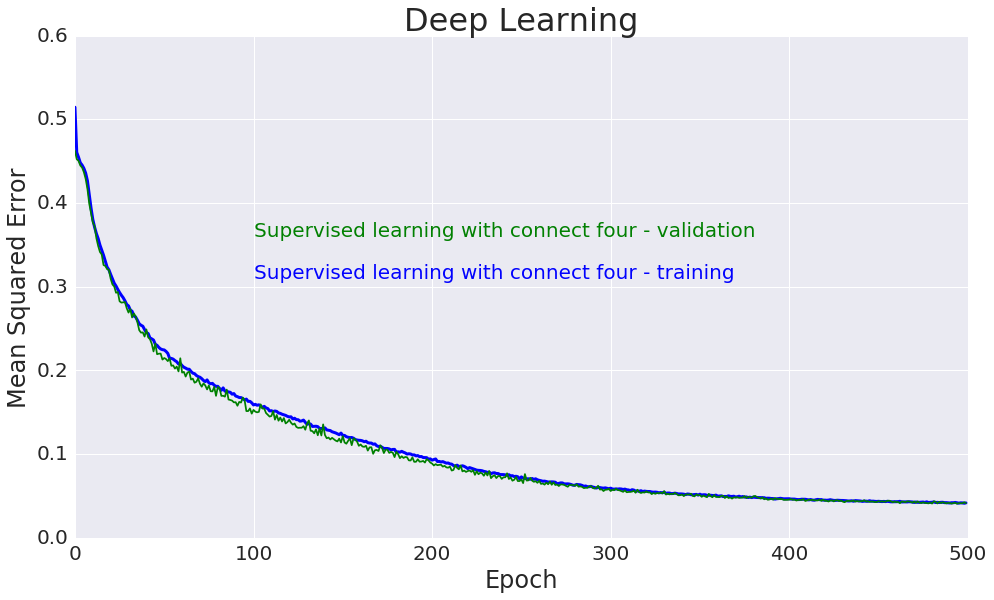

In [17]:
plt.figure(figsize=(16,9))
plt.plot(plot_list[:,0],plot_list[:,1],color = 'blue',linewidth=3)
plt.plot(plot_list[:,0],plot_list[:,2],color = 'green')
# plt.plot(50*plot_list2[:,0]+plot_list2[:,1]-900,plot_list2[:,2],color = 'red')
plt.title('Deep Learning',fontsize=32)
plt.xlabel('Epoch',fontsize=24)
plt.ylabel('Mean Squared Error',fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
# ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
# ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
plt.text(100, 0.31,"Supervised learning with connect four - training",fontsize=20,color='blue')
plt.text(100, 0.36,"Supervised learning with connect four - validation",fontsize=20,color='green')
# plt.text(410, 0.51,"Reinforcement learning with tic tac toe - loss",fontsize=20,color='red')
plt.savefig('supervised_c4_new.png')
plt.show

In [ ]:
f = open('TD_connect_four.txt','r')
plot_list = f.read().splitlines()
plot_list = np.array([[float(x) for x in item[1:-1].split(',')] for item in plot_list])

In [ ]:
plt.plot(500*plot_list[:,0]+plot_list[:,1],plot_list[:,2])
plt.show

In [ ]:
f = open('supervised_tictactoe.txt','r')
plot_list = f.read().splitlines()
plot_list = np.array([[float(x) for x in item[1:-1].split(',')] for item in plot_list])

<function matplotlib.pyplot.show>

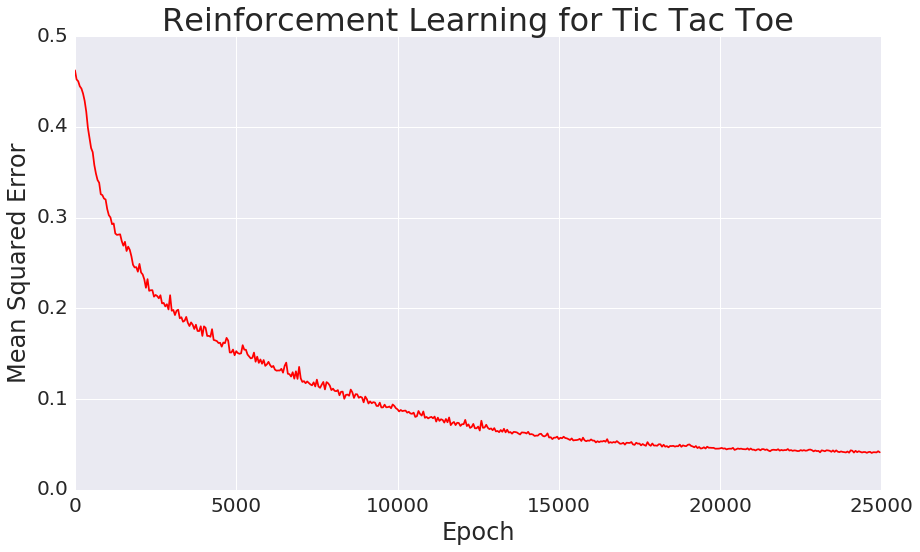

In [16]:
plt.figure(figsize=(16,9))
plt.plot(50*plot_list[:,0]+plot_list[:,1],plot_list[:,2],color = 'red')
plt.title('Reinforcement Learning for Tic Tac Toe',fontsize=32)
plt.xlabel('Epoch',fontsize=24)
plt.ylabel('Mean Squared Error',fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
# ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
# ax.spines["left"].set_visible(False)    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
plt.subplots_adjust(bottom = 0.2, left = 0.2)
plt.savefig('reinforcement_ttt.png')
plt.show
  